In [1]:
#!pip install packagename
# importing modules
import geopandas as gpd
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import chdir as cd
import time
import fiona
from datetime import date

# Core-based Statistical Area (CBSA) Data

In [2]:
US_states = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\cb_2020_us_state_5m.zip') # tl_2020_us_state
US_states = US_states.to_crs('EPSG:9311')

# adding metropolitan/Micropolitan geometry & population data
MSA_geo_20 = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\cb_2020_us_cbsa_5m.zip') # tl_2020_us_cbsa
MSA_geo_20 = MSA_geo_20.to_crs('EPSG:9311')
MSA_geo_20.columns

# CBSA to place area factors from GeoCorr2022 using population weights
cbsa_2_place_geocorr = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\CBSA data\cbsa_2_place.csv', header=1, encoding='latin-1')

cbsa_2_place_geocorr['State code']  = cbsa_2_place_geocorr['State code'].astype(str).str.rjust(2,'0')
cbsa_2_place_geocorr['Place code']  = cbsa_2_place_geocorr['Place code'].astype(str).str.rjust(5,'0')
cbsa_2_place_geocorr['GEOID_place'] = cbsa_2_place_geocorr[['State code','Place code']].astype(str).agg(''.join, axis=1)
cbsa_2_place_geocorr['GEOID_cbsa']  = cbsa_2_place_geocorr['Core-based statistical area code'].astype(str)
cbsa_2_place_geocorr

cbsa_2_place = cbsa_2_place_geocorr[['GEOID_cbsa',  'cbsa20-to-place allocation factor', 'GEOID_place']]

# Adding commuting time for cbsa 
cbsa_commute_time = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\CBSA data\ACSST5Y2020.S0801-Data.csv')
cbsa_tt = cbsa_commute_time[['GEO_ID', 'NAME', 'S0801_C01_046E']] # taking the column with mean travel time
cbsa_tt = cbsa_tt.tail(-1).reset_index(drop = True)
cbsa_tt['GEOID_cbsa'] = cbsa_tt['GEO_ID'].str[9:]
cbsa_tt.rename({'S0801_C01_046E':'tt_2_work'}, axis =1, inplace = True)
cbsa_tt

cbsa_data = cbsa_2_place.merge(cbsa_tt[['GEOID_cbsa', 'tt_2_work']], on = 'GEOID_cbsa', how = 'outer')
cbsa_2_place.shape, cbsa_tt.shape, cbsa_data.shape


cbsa_data['tt_2_work'] = cbsa_data['tt_2_work'].astype(float)
df_cbsa = cbsa_data.groupby('GEOID_place').agg({'GEOID_cbsa': 'count',
                                      'cbsa20-to-place allocation factor': 'sum',
                                      'tt_2_work': 'max'}).reset_index()

In [3]:
cbsa_data[cbsa_data['GEOID_place'].duplicated(keep = False)].sort_values(['GEOID_place']) #.nunique()

,GEOID_cbsa,cbsa20-to-place allocation factor,GEOID_place,tt_2_work
7924,23460,0.0088,0101660,25.0
2269,13820,0.0000,0101660,26.8
324,10700,0.0864,0102116,24.6
5544,18980,0.0003,0102116,26.0
325,10700,0.0922,0107912,24.6
...,...,...,...,...
12769,32420,0.2876,7299999,23.0
24705,49500,0.5396,7299999,23.7
10174,27580,0.7927,7299999,22.8
20336,41900,0.6039,7299999,25.8


# Urbanized area data

In [4]:
# urban area from 2020 census definition to place area conversion from GeoCorr22
ua_2_place_geocorr = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\CBSA data\UA_2_Place_populationweighted.csv', header=1, encoding='latin-1')
ua_2_place_geocorr['State code'] = ua_2_place_geocorr['State code'].astype(str).str.rjust(2,'0')
ua_2_place_geocorr['Place code'] = ua_2_place_geocorr['Place code'].astype(str).str.rjust(5,'0')
ua_2_place_geocorr['GEOID'] = ua_2_place_geocorr[['State code','Place code']].astype(str).agg(''.join, axis=1)
ua_2_place_geocorr['Urban area (2022)'] = ua_2_place_geocorr['Urban area (2022)'].astype(str).str.rjust(5,'0')
ua_2_place_geocorr['GEOID'].nunique()
ua_2_place_geocorr['Urban area (2022)'].nunique()
ua_2_place = ua_2_place_geocorr[['Urban area (2022)', 'Total population (2020 Census)', 'ua-to-place allocation factor', 'GEOID']]

# Population in urban area from GeoCorr2022
ua_population = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\CBSA data\ua_population_20.csv', header=1, encoding='latin-1')
ua_population['Urban area (2022)'] = ua_population['Urban area (2022)'].astype(str).str.rjust(5,'0')

ua_population.shape, ua_2_place.shape

df_ua = ua_2_place.merge(ua_population[['Urban area (2022)', 'Total population (2020 Census)']], on = 'Urban area (2022)', how = 'outer')

df_ua.rename({'Total population (2020 Census)_x':'population_place',
             'Total population (2020 Census)_y':'population_ua'}, 
             axis =1, inplace = True)

df_ua_place_level = df_ua.groupby('GEOID').agg({'Urban area (2022)':'count',
                                                'population_place': 'sum',
                                                'ua-to-place allocation factor': ['min', 'max'],
                                                'population_ua':['min', 'max'],
                                               }).reset_index()

df_ua_place_level.columns = [c[0] + "_" + c[1] for c in df_ua_place_level.columns]

In [5]:
df_ua_place_level.head(5)

,GEOID_,Urban area (2022)_count,population_place_sum,ua-to-place allocation factor_min,ua-to-place allocation factor_max,population_ua_min,population_ua_max
0,0100100,1,133,0.0,0.000,66336356,66336356
1,0100124,1,2358,0.0,0.000,66336356,66336356
2,0100460,2,4366,0.0,0.005,776468,66336356
3,0100484,1,659,0.0,0.000,66336356,66336356
4,0100676,1,225,0.0,0.000,66336356,66336356


# Place (city) data

In [9]:
'''
source: https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2019/TGRSHP2019_TechDoc.pdf
MTFCC: G4110 (incorporated place) and G4210 (census designated place)
PCICBSA: Current metropolitan or micropolitan statistical area principal city indicator
'''
# importing spatial data 
US_places =  gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\compiled.shp')
US_places = US_places.to_crs('EPSG:9311')
US_places['PCICBSA'].value_counts()
# dropping columns that will not be used in the anaysis
places_US = US_places.drop(['PLACEFP', 'PLACENS', 'NAME', 'LSAD', 'CLASSFP',
                            'PCINECTA','FUNCSTAT', 'AWATER', 'INTPTLAT', 
                            'INTPTLON', ], axis =1)

# importing housing density calculated from Census Tract level, weighted by no of housing units
df_weighted_density = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\weighted_housingUnits_for_places.csv')
df_weighted_density['GEOID'] = df_weighted_density['GEOID_place'].astype(str).str.rjust(7, '0')


# merging spatial data with dataframe
places_weighted_housing = places_US.merge(df_weighted_density[['GEOID', 'weighted_HU_density_sqmi']], 
                                          on = 'GEOID')
places_weighted_housing.shape, places_weighted_housing.columns

# importing current trend estimates and joining with geodataframe
current_trend = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\current_trend_from_census.csv', dtype = {'GEOID':str})
current_trend['label'] = current_trend['trend2']

current_trend.shape, places_US.shape, df_weighted_density.shape

# this dataframe contains spatial data, housing density and current trend
df_current_trend = places_weighted_housing.merge(current_trend[['P_2020', 'label', 'density_km2', 'GEOID']], 
                                    on = 'GEOID', how = 'outer')

df_current_trend.columns, df_current_trend.isna().sum()

expected_trend_df = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\future trend from SSP.csv', 
                                index_col =0, dtype = {'GEOID': str, 'STATEFP': str})


# expected_trend_df['GEOID'] = expected_trend_df['GEOID'].astype(str).str.rjust(7, '0')
df_forecasted_trend = df_current_trend.merge(expected_trend_df[['GEOID', 'CensusPop_20', 'future trend from SSP 1', 'future trend from SSP 2',
                                                                'future trend from SSP 3', 'future trend from SSP 4', 'future trend from SSP 5', 
                                                                'REGION', 'DIVISION']],
                                                on= 'GEOID', how = 'outer')


In [10]:
# commute time for places form ACS data
places_commute_time = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\PLACE data\ACSST5Y2020.S0801-Data.csv')
place_tt = places_commute_time[['GEO_ID', 'NAME', 'S0801_C01_046E', 'S0801_C01_048E', 'S0801_C01_049E', 'S0801_C01_050E', 'S0801_C01_051E']]
place_tt = place_tt.tail(-1).reset_index(drop = True)
place_tt['GEOID'] = place_tt['GEO_ID'].str[9:]
place_tt.rename({'S0801_C01_046E':'tt_2_work_place',
                 'S0801_C01_048E':'no_veh', 
                 'S0801_C01_049E':'veh_1',
                 'S0801_C01_050E':'veh_2', 
                 'S0801_C01_051E':'veh_3_or+'}, axis =1, inplace = True)

place_tt[['no_veh', 'veh_1', 'veh_2', 'veh_3_or+']]  = place_tt[['no_veh', 'veh_1', 'veh_2', 'veh_3_or+']] .apply(pd.to_numeric, errors='coerce')
place_tt['veh_2_or+'] = place_tt['veh_2'] + place_tt['veh_3_or+']
print(place_tt.columns)

df_with_trend_forecast = df_forecasted_trend.merge(place_tt[['GEOID', 'tt_2_work_place', 'no_veh','veh_1','veh_2_or+']], on = 'GEOID', how = 'left')
# df_with_trend_forecast.isna().sum()

C:\Users\uttar\AppData\Local\Temp\ipykernel_13868\3314213435.py:2: DtypeWarning: Columns (2,3,4,5,102,103,104,105,186,187,188,189,230,231,232,233,330,331,332,333,414,415,416,417,458,459,460,461,558,559,560,561,642,643,644,645) have mixed types. Specify dtype option on import or set low_memory=False.
  places_commute_time = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\PLACE data\ACSST5Y2020.S0801-Data.csv')


Index(['GEO_ID', 'NAME', 'tt_2_work_place', 'no_veh', 'veh_1', 'veh_2',
       'veh_3_or+', 'GEOID', 'veh_2_or+'],
      dtype='object')


# Merging CBSA data & Urbanized area data with Place data

In [11]:
df_0 = df_with_trend_forecast.merge(df_cbsa, left_on = 'GEOID', right_on = 'GEOID_place', how = 'outer')
# df_0 = df_0.merge(df_uac, left_on = 'GEOID', right_on = 'GEOID', how = 'outer')

df_0 = df_0.merge(df_ua_place_level, left_on = 'GEOID', right_on = 'GEOID_', how = 'outer')

In [12]:
# df_0.isna().sum()

In [13]:
df_0['tt_2_work_place'].replace(['N', '-'], np.nan, inplace= True)
df_0['tt_2_work_place'] = df_0['tt_2_work_place'].astype(float)

In [14]:
# df_0[['tt_2_work_place', 'tt_2_work']].isna().sum()

In [15]:
df_0.columns

Index(['STATEFP', 'GEOID', 'NAMELSAD', 'PCICBSA', 'MTFCC', 'ALAND', 'geometry',
       'weighted_HU_density_sqmi', 'P_2020', 'label', 'density_km2',
       'CensusPop_20', 'future trend from SSP 1', 'future trend from SSP 2',
       'future trend from SSP 3', 'future trend from SSP 4',
       'future trend from SSP 5', 'REGION', 'DIVISION', 'tt_2_work_place',
       'no_veh', 'veh_1', 'veh_2_or+', 'GEOID_place', 'GEOID_cbsa',
       'cbsa20-to-place allocation factor', 'tt_2_work', 'GEOID_',
       'Urban area (2022)_count', 'population_place_sum',
       'ua-to-place allocation factor_min',
       'ua-to-place allocation factor_max', 'population_ua_min',
       'population_ua_max'],
      dtype='object')

# Labeling places as URBAN < SUBURBAN < RURAL

In [16]:
new_col = 'city type'
area_factor = 'ua-to-place allocation factor_max'
msa_area_factor = 'cbsa20-to-place allocation factor'
ua_population = 'population_ua_max'
population = 'CensusPop_20'
housingUnit_density = 'weighted_HU_density_sqmi'
city_type = 'PCICBSA'
df = df_0.copy()
df[new_col] = " "

# DEFINING URBAN < SUBURBAN < RURAL BASED ON THE RULES OF THE FOLLOWING LINK
# Apply conditions for urban-suburban-rural
# source: https://bjs.ojp.gov/content/pub/pdf/cusrancvs.pdf
# Suburban and rural places will be further differentiated

for i in df.index:
    if df.loc[i,city_type] == 'Y':
        if (df.loc[i, ua_population] >= 500000) & (df.loc[i, housingUnit_density] >= 3000) & (df.loc[i, area_factor] > 0):
            df.loc[i, new_col] = 'urban'
        else:
            df.loc[i, new_col] = 'suburban'
            
    elif (df.loc[i,city_type] == 'N') & (df.loc[i, area_factor] > 0):
        if (df.loc[i, ua_population] >= 500000) & (df.loc[i, housingUnit_density] >= 4000):
            df.loc[i, new_col] = 'urban'
        else:
            if (df.loc[i, 'tt_2_work_place'] <= df.loc[i, 'tt_2_work']):
                df.loc[i, new_col] = 'suburban'
            else:
                df.loc[i, new_col] = 'periurban'
                
    elif (df.loc[i,city_type] == 'N') & (df.loc[i, area_factor] <= 0):
        if (df.loc[i, population] >= 50000) & (df.loc[i, housingUnit_density] >= 5000) | (
            df.loc[i, population] >= 10000) & (df.loc[i, housingUnit_density] >= 10000):
            
            df.loc[i, new_col] = 'urban'
        else:
            df.loc[i, new_col] = 'rural'          

    else:
        df.loc[i, new_col] = 'not enough data'
        


In [17]:
df.shape,  df['city type'].value_counts()#/df['city type'].value_counts().sum()
# df[df['PCICBSA'] == 'Y']['city type'].value_counts()/df[df['PCICBSA'] == 'Y']['city type'].value_counts().sum()

((32069, 35),
 city type
 rural              18592
 suburban            7030
 periurban           5874
 urban                324
 not enough data      249
 Name: count, dtype: int64)

(-2246944.04, 918095.9)

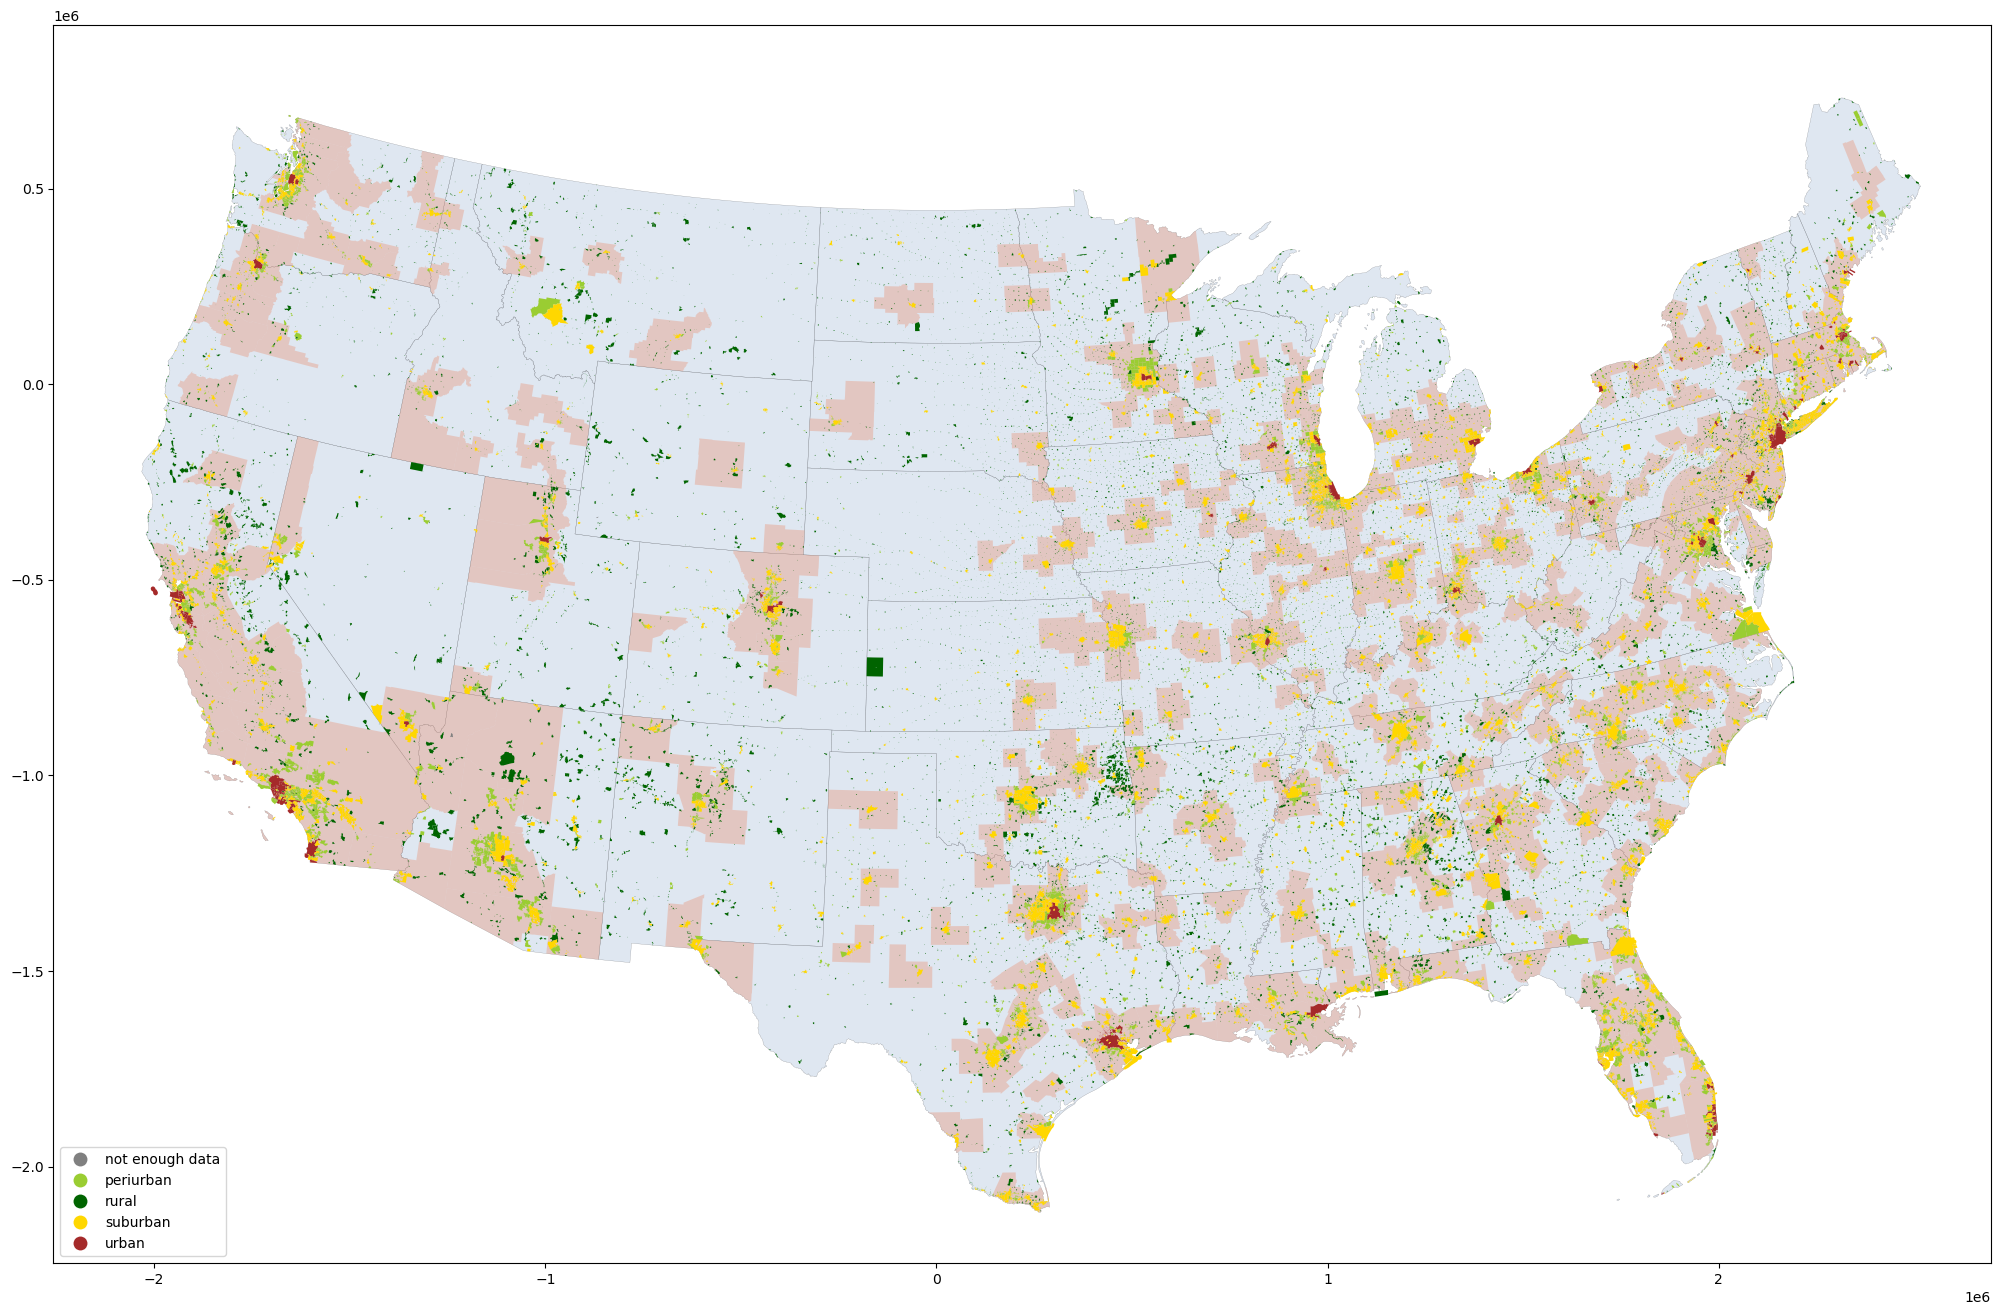

In [18]:
# to check if the intersected areas fall inside the MSAs
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(25,18))
US_states.plot(ax=ax, facecolor = 'lightsteelblue', edgecolor='black', linewidth=0.2, alpha = 0.4)
MSA_geo_20[MSA_geo_20['LSAD']=='M1'].plot(ax=ax, alpha = 0.4, color = 'darksalmon')

df.plot(ax= ax, column = 'city type', legend = True, legend_kwds={'loc': 'lower left'}, cmap = matplotlib.colors.ListedColormap(['grey', 'yellowgreen', 'darkgreen','gold','brown',])) 

xlim = ([-2257388.37, 2695859.75]) 
ylim = ([-2246944.04, 918095.9])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [19]:
# import and add median income for cities from ACS data
income_df = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\PLACE data\ACSST5Y2020.S1901-Data.csv')
income_df = income_df[['GEO_ID', 'NAME', 'S1901_C01_012E']]
income_df = income_df.tail(-1).reset_index(drop = True)
income_df['GEOID'] = income_df['GEO_ID'].str[9:]
income_df.rename({'S1901_C01_012E':'median_income'}, axis =1, inplace = True)
df = df.merge(income_df[['median_income', 'GEOID']], on = 'GEOID')

# Income values with 2500- and 250,000+ is converted to numbers for str to float conversion
df['median_income'] = df['median_income'].replace('-', np.nan)
df['median_income'] = df['median_income'].replace('2,500-', '2499')
df['median_income'] = df['median_income'].replace('250,000+', '250001')
df['median_income'] = df['median_income'].astype(float)

C:\Users\uttar\AppData\Local\Temp\ipykernel_13868\2991260479.py:2: DtypeWarning: Columns (2,3,4,5,66,67,68,69,130,131,132,133,194,195,196,197) have mixed types. Specify dtype option on import or set low_memory=False.
  income_df = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\PLACE data\ACSST5Y2020.S1901-Data.csv')


# Chart/graphs from analysis

In [20]:
# Replacing nan values in STATEFP with respective values from GEOID

df.loc[df['STATEFP'].isnull(),'STATEFP'] = df['GEOID'].str[:2]

# Replacing nan values in region with respective values for that region
df[df['REGION'].isnull()]['STATEFP'].unique()
# Northeast = []
Midwest = ['29', '46']
South = ['13', '21', '37', '40', '48', '54']
West = ['02', '04', '06', '08', '35', '49', '56'] 
        
df['REGION'] = np.where(df["STATEFP"].isin(Midwest), 2, df['REGION'])
df['REGION'] = np.where(df["STATEFP"].isin(South), 3, df['REGION'])
df['REGION'] = np.where(df["STATEFP"].isin(West), 4, df['REGION'])


In [21]:
for i in range(len(df)):
    # print(i)
    if df.loc[i,'REGION'] == 1:
        df.loc[i,'REGION'] = 'Northeast'
    elif df.loc[i,'REGION'] == 2:
        df.loc[i,'REGION'] = 'Midwest' 
    elif df.loc[i,'REGION'] == 3:
        df.loc[i,'REGION'] = 'South'
    elif df.loc[i,'REGION'] == 4:
        df.loc[i,'REGION'] = 'West'
    else:
        df.loc[i,'REGION'] = 'Outside Contiguous US'   

C:\Users\uttar\AppData\Local\Temp\ipykernel_13868\3734878489.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'South' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i,'REGION'] = 'South'


In [22]:
df['city type'].value_counts()

city type
rural              18592
suburban            7030
periurban           5873
urban                324
not enough data       89
Name: count, dtype: int64

In [23]:
# df.isna().sum()

In [24]:
df[['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3',
       'future trend from SSP 4', 'future trend from SSP 5', 'REGION','no_veh', 'veh_1', 'veh_2_or+', 'city type', 'median_income']].dtypes

future trend from SSP 1     object
future trend from SSP 2     object
future trend from SSP 3     object
future trend from SSP 4     object
future trend from SSP 5     object
REGION                      object
no_veh                     float64
veh_1                      float64
veh_2_or+                  float64
city type                   object
median_income              float64
dtype: object

In [25]:
df_no_nan = df[df['city type'] != 'not enough data']
df.shape, df_no_nan.shape

((31908, 36), (31819, 36))

In [26]:
df_no_nan['city type'].value_counts()

city type
rural        18592
suburban      7030
periurban     5873
urban          324
Name: count, dtype: int64

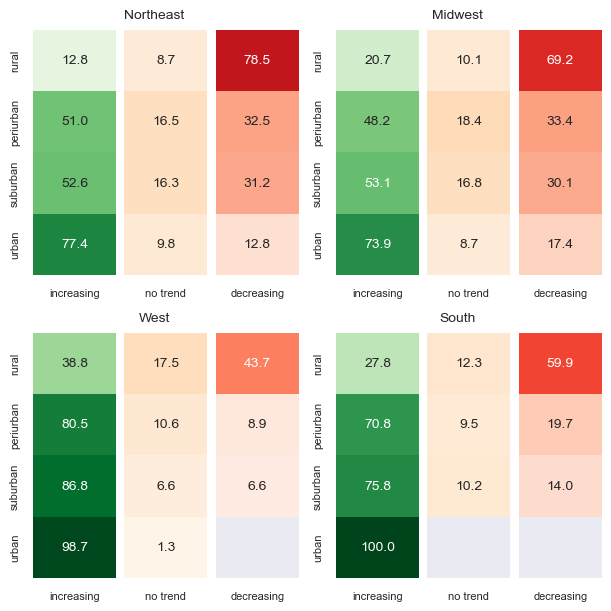

In [27]:
trend_column = 'future trend from SSP 1'
regions = ['Northeast', 'Midwest', 'West', 'South']

fig = plt.figure(figsize=(6, 6), constrained_layout=True)
subfigs = fig.subfigures(2, 2)
for outerind, (subfig, region) in enumerate(zip(subfigs.flat, regions)):

    grouped_data = df_no_nan[(df_no_nan['REGION'] == region)].groupby(['city type',trend_column])[['GEOID']].count()
        # Convert the grouped data into a hierarchical structure
    hierarchical_data = grouped_data.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)
    hierarchical_data.index = pd.CategoricalIndex(hierarchical_data.index, categories= ['rural', 'periurban', 'suburban', 'urban'])
    hierarchical_data.sort_index(level=0, inplace=True)

    column_order = ['increasing', 'no trend', 'decreasing']
    # after pandas 0.21.0
    hierarchical_data = hierarchical_data.reindex(column_order, axis=1,)
    # Normalize the data
    normalized_data = hierarchical_data.apply(lambda x: x*100/x.sum(), axis=1)
    cm = ['Greens', 'Oranges', 'Reds']
    sns.set(font_scale = 0.5)
    # source: https://stackoverflow.com/questions/59482395/heatmap-each-column-with-different-color-and-scaling-in-r-python
        
    axs = subfig.subplots(1, normalized_data.columns.size, gridspec_kw={'wspace': 0})
    for i, (s, a, c) in enumerate(zip(normalized_data.columns, axs, cm)):
        g = sns.heatmap(np.array([normalized_data[s].values]).T, 
                    yticklabels=normalized_data.index, 
                    xticklabels=[s], 
                    annot=True, annot_kws={"size": 10},
                    fmt='.1f', ax=a, cmap=c, 
                    vmin=0, vmax=100, cbar=False)
        
        a.tick_params(axis='both', labelsize=8)
        a.grid(False)
        if i>0:
            a.yaxis.set_ticks([])
            # a.tick_params(axis='both', labelsize=8)
        
    subfig.suptitle(region, fontsize = 10)
    
fig.savefig(r'D:\Work\Box Sync\NC Figures\Trend with DoU_Revise' + str(trend_column) + '.png',
            dpi = 300, bbox_inches='tight')   


# Export df attributes

In [29]:
df['veh_<=_1'] = df[['no_veh', 'veh_1']].sum(axis=1)
df['veh 1+'] = df[['veh_1', 'veh_2_or+']].sum(axis=1)

df[['STATEFP', 'GEOID', 'NAMELSAD','weighted_HU_density_sqmi', 'label', 'density_km2','CensusPop_20', 
    'future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3','future trend from SSP 4', 'future trend from SSP 5', 
    'REGION', 'DIVISION', 'tt_2_work_place', 'no_veh', 'veh_1', 'veh_2_or+', 'GEOID_place', 'GEOID_cbsa', 'cbsa20-to-place allocation factor',
    'tt_2_work', 'GEOID_', 'Urban area (2022)_count', 'population_place_sum', 'ua-to-place allocation factor_min',
    'ua-to-place allocation factor_max', 'population_ua_min', 'population_ua_max', 'city type', 'median_income', 'veh 1+',
    'veh_<=_1']].to_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\df_attributes.csv')


# Separate plots for each regions

In [26]:
# # Group the data by the three categorical variables and sum the values
# trend_column = 'future trend from SSP 4'
# regions = ['Northeast', 'Midwest', 'West', 'South']

# df_no_nan = df[(df['city type'] != 'not enough data')]
# print(df_no_nan.shape)
# # for ax, region in zip(axes.flatten(), regions):
# for region in regions:
#     grouped_data = df_no_nan[(df_no_nan['REGION'] == region)].groupby(['city type',
#                                                                         trend_column])[['GEOID']].count()
#     # Convert the grouped data into a hierarchical structure
#     hierarchical_data = grouped_data.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)
    
#     hierarchical_data.index = pd.CategoricalIndex(hierarchical_data.index, categories= ['rural', 'periurban', 'suburban', 'urban'])
#     hierarchical_data.sort_index(level=0, inplace=True)

#     column_order = ['increasing', 'no trend', 'decreasing']
#     # after pandas 0.21.0
#     hierarchical_data = hierarchical_data.reindex(column_order, axis=1,)
    
#     # Normalize the data
#     normalized_data = hierarchical_data.apply(lambda x: x*100/x.sum(), axis=1)


    
#     # sns.set(font_scale = 1.3)
#     # source: https://stackoverflow.com/questions/59482395/heatmap-each-column-with-different-color-and-scaling-in-r-python
#     cm = ['Greens', 'Oranges', 'Reds']
#     f, axs = plt.subplots(1, normalized_data.columns.size, figsize=(6, 5), gridspec_kw={'wspace': 0})
#     for i, (s, a, c) in enumerate(zip(normalized_data.columns, axs, cm)):
#         sns.heatmap(np.array([normalized_data[s].values]).T, 
#                     yticklabels=normalized_data.index, 
#                     xticklabels=[s], 
#                     annot=True, fmt='.1f', ax=a, cmap=c, 
#                     vmin=0, vmax=100, cbar=False)
#         if i>0:
#             a.yaxis.set_ticks([])
#         f.suptitle(region)

#     f.savefig(r'D:\Work\Box Sync\PhD_Work_Uttara\NC_submission_shared\Final_submission\Final_plots\Trend with DoU_Revise' + str(region)+ str(trend_column) + '.png',
#             dpi = 300, bbox_inches='tight')

In [27]:
crosstabRes = pd.crosstab(index = df['city type'], columns = df['label'])
from scipy.stats import chi2_contingency
chisqRes =  chi2_contingency(crosstabRes)
print('P-value of the chi- squared test: ', chisqRes[1])
if chisqRes[1] < 0.05:
    print('The variables have correlation.')
else:
    print('not correlated')

P-value of the chi- squared test:  0.0
The variables have correlation.


In [28]:
df['city type'] = pd.Categorical(df['city type'], ["urban", "suburban", "periurban", "rural", "not enough data"])
df = df.sort_values("city type").reset_index(drop =True)


<Axes: >

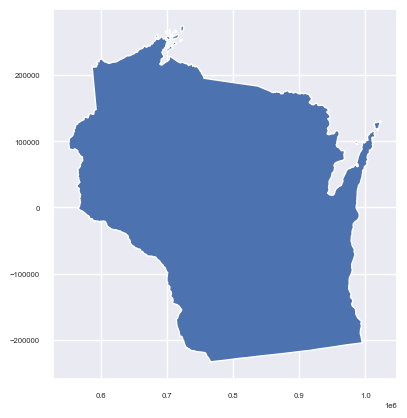

In [29]:
US_states[US_states['NAME'] == 'Wisconsin'].plot()

# Urban rural continum plot

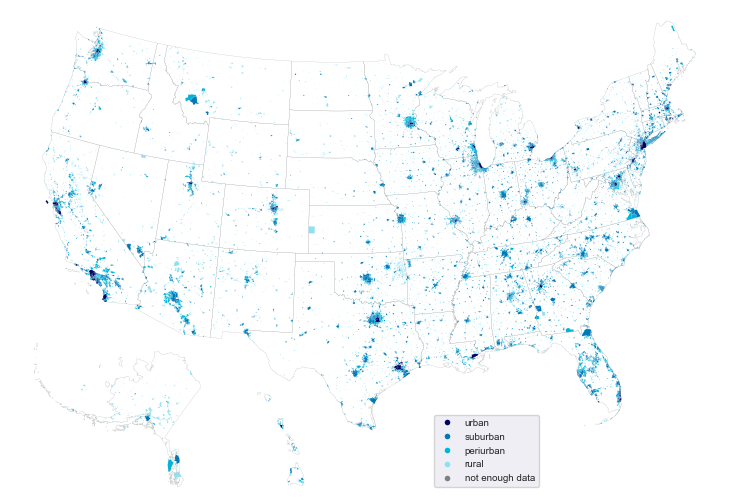

In [30]:
col = "city type"
cmap_color = matplotlib.colors.ListedColormap(['#03045e','#0077b6', '#00b4d8', '#90e0ef','grey',]) # ['grey', 'yellowgreen', 'darkgreen','gold','brown',]'darkblue','royalblue', 'darkturquoise', 'cyan','grey',

mm = 1/25.4  # milimeters in inches

fig, continental_ax = plt.subplots(figsize=(185*mm, 150*mm))
alaska_ax = continental_ax.inset_axes([.01, .01, .28, .30])
hawaii_ax = continental_ax.inset_axes([.25, .01, .25, .20])

# Set bounds to fit desired areas in each plot
continental_ax.set_xlim(-2257388.37, 2695859.75)
continental_ax.set_ylim(-2546944.04, 808080.9)

alaska_ax.set_xlim(-4383115.86156959, -1515327.22537998)
alaska_ax.set_ylim(1458524.37417163, 3919523.37426209)

hawaii_ax.set_xlim(-5812090.887043, -5452538.83170424)   # complete bounds 
hawaii_ax.set_ylim(-1064618.58269969, -431238.37803499)

# Plot the data per area - requires passing the same choropleth parameters to each call
# because different data is used in each call, so automatically setting bounds won’t work
#vmin, vmax = df['ALAND'].agg(['min', 'max'])
US_states.plot(ax=continental_ax, facecolor = 'none', edgecolor='gray', linewidth=0.1)
df.plot(column=col, 
        ax=continental_ax,
        cmap=cmap_color,
        edgecolor = 'None',
        alpha = 1,
        legend = True,
        legend_kwds={'loc': 'lower right', 'fontsize': 7,
                    'markerscale': 0.4}) #, vmin=vmin, vmax=vmax)

leg = continental_ax.get_legend()
leg.set_bbox_to_anchor((0.05, 0.0, 0.7, 0.2))

US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.1, ax=alaska_ax)
df.plot(column=col, cmap=cmap_color, edgecolor = 'None', ax=alaska_ax) #, vmin=vmin, vmax=vmax)
US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.1, ax=hawaii_ax)
df.plot(column=col, cmap=cmap_color, edgecolor = 'None', ax=hawaii_ax) #, vmin=vmin, vmax=vmax)

# continental_ax.set_title('TITLE', fontsize=15, pad=5) 
#from ACS 5-yr population estimates using data from 2010-2020, (b) 
# remove ticks
for ax in [continental_ax, alaska_ax, hawaii_ax]:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')
    plt.tight_layout()
    plt.axis('off') 
        
fig.patch.set_visible(False)
fig.tight_layout(pad=1)    
    
fig.savefig(r'D:\Work\Box Sync\NC Figures\urban_rural_continuum_bluepalette' +
            '.png', dpi = 300, bbox_inches='tight')

fig.savefig(r'D:\Work\Box Sync\NC Figures\urban_rural_continuum_bluepalette' + 
            '.pdf', dpi = 300, bbox_inches='tight')

# FOR CHECK with Urban definition report

(-430006.06386062, -352453.50247821)

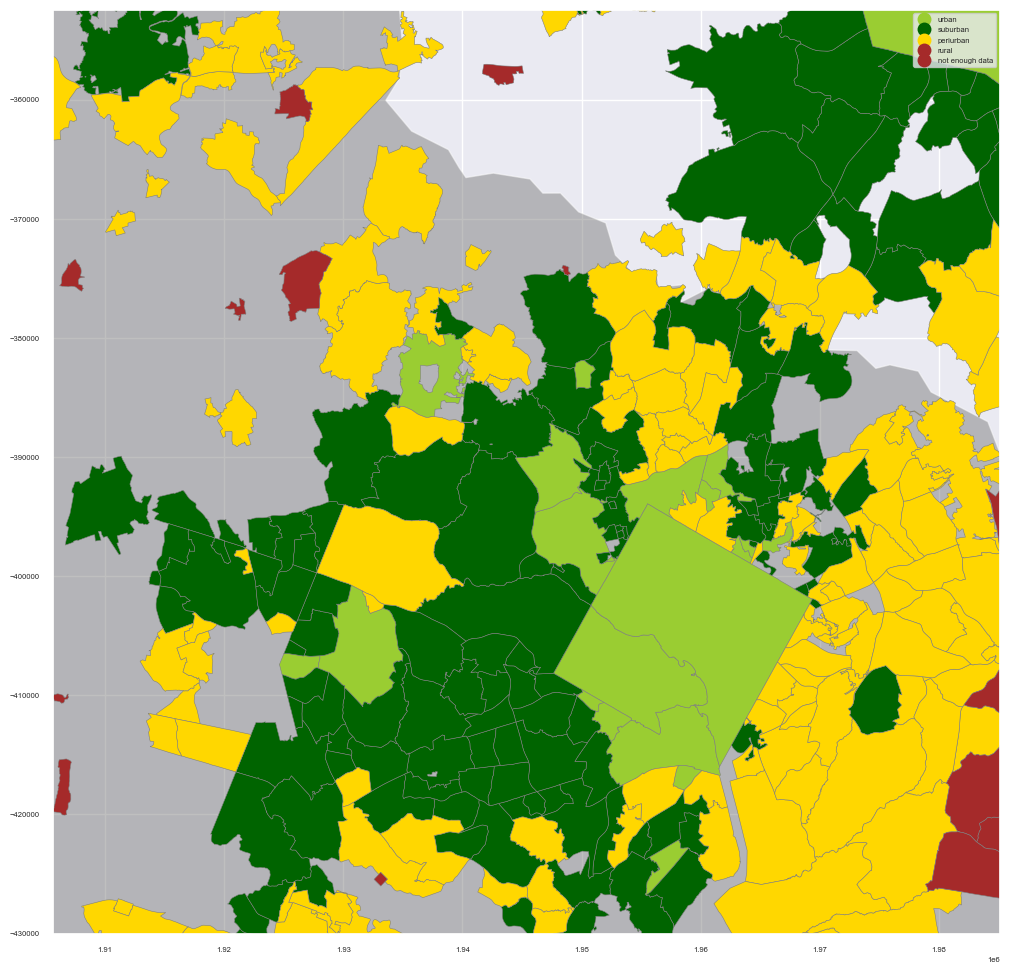

In [31]:

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(22,12))
cmap_color = matplotlib.colors.ListedColormap(['yellowgreen', 'darkgreen','gold','brown',])
MSA_geo_20[MSA_geo_20['NAMELSAD'].str.contains('DC')].plot(ax=ax, alpha = 0.5, color = 'gray') # [MSA_data_20['LSAD']=='M1']
df[(df['STATEFP'] == '11') | (df['STATEFP'] == '24') | (df['STATEFP'] == '51')].plot(ax= ax, cmap=cmap_color, column  = 'city type', 
                                                                                     edgecolor='gray', linewidth=0.4, legend = True)
xlim = ([1905651.2601596, 1985109.28733622]) 
ylim = ([-430006.06386062,-352453.50247821])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Vehicle ownership vs REGION→Trend

In [32]:
# df_plot = df_no_nan
# df_plot
# trend_column = "future trend from SSP 4"
# sns.set(font_scale = 1.9)
# g = sns.catplot(
#     data=df_plot, y="REGION", x='veh_2_or+', col=trend_column, hue = 'city type', col_wrap =3,
#     order=['Northeast', 'Midwest', 'South', 'West'],
#     kind="strip", dodge = True, height=7, aspect= 1.2, hue_order= ['rural', 'periurban', 'suburban', 'urban'],
#     palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red'],
#     col_order = ['increasing', 'no trend', 'decreasing']
# )


# Median income vs REGION→Trend

In [33]:
# trend_col = 'future trend from SSP 4'
# df_scatter = df[['median_income', 'CensusPop_20', 'density_km2', 'city type', 'REGION', trend_col,]].dropna()
# df_scatter = df_scatter[(df_scatter['REGION'] != 'Outside Contiguous US') & (df_scatter['density_km2'] < 15000)]
# df_scatter['median income in thousands'] = df_scatter['median_income']/1000
# df_scatter.dtypes

# sns.set(font_scale = 1.4)
# g = sns.catplot(data=df_scatter, x='median income in thousands', y = 'REGION', alpha =0.7,
#             order=['Northeast', 'Midwest', 'South', 'West'],
#             col_order = ['increasing', 'no trend', 'decreasing'],
#             hue_order= ['rural', 'periurban', 'suburban', 'urban'],
#             palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red'],
#             hue="city type", dodge=True, col=trend_col,
#            )

# sns.move_legend(g, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=5, frameon=False)
# # plt.legend(loc='upper center', bbox_to_anchor=(-0.5, -0.20),
# #           fancybox=True, shadow=True, ncol=4)
# plt.savefig(r'D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\trend_vs_median_income' + str(trend_col) +'.png', 
#             dpi =300, bbox_inches = 'tight')

<Axes: >

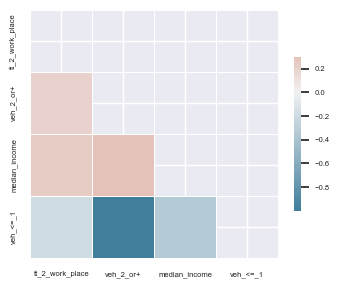

In [34]:
# Compute the correlation matrix
corr = df[['tt_2_work_place', 'veh_2_or+', 'median_income', 'veh_<=_1']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(4, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# For Illinois Depopulation Study

<>:32: SyntaxWarning: invalid escape sequence '\W'
<>:32: SyntaxWarning: invalid escape sequence '\W'
C:\Users\uttar\AppData\Local\Temp\ipykernel_16620\3310411982.py:32: SyntaxWarning: invalid escape sequence '\W'
  fig.savefig('D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\Trend with DoU_IL' + str(trend_column) + '.png',
C:\Users\uttar\AppData\Local\Temp\ipykernel_16620\3310411982.py:32: SyntaxWarning: invalid escape sequence '\W'
  fig.savefig('D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\Trend with DoU_IL' + str(trend_column) + '.png',


NameError: name 'df_IL' is not defined

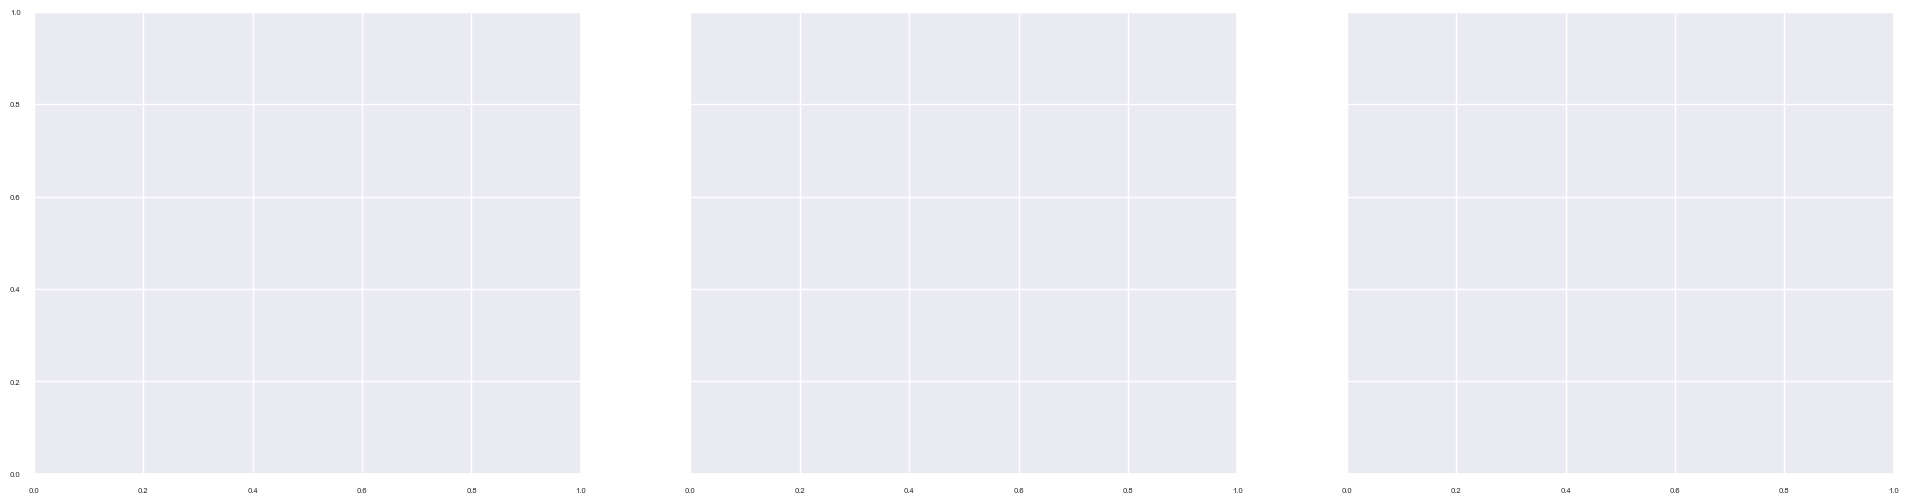

In [35]:
# Group the data by the three categorical variables and sum the values
trend_column = ['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 4']
df_IL = df[df['STATEFP']= '17']
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)

for ax, col in zip(axes, trend_column):
    grouped_data = df_IL[(df_IL['city type'] != 'not enough data') & (df_IL['REGION'] == 'Midwest')].groupby(['city type',
                                                                                                   col])[['GEOID']].count()
    # Convert the grouped data into a hierarchical structure
    hierarchical_data = grouped_data.pivot_table(values='GEOID', index=['city type', ], columns=col ,)
    
    hierarchical_data.index = pd.CategoricalIndex(hierarchical_data.index, categories= ['rural', 'periurban', 'suburban', 'urban'])
    hierarchical_data.sort_index(level=0, inplace=True)

    column_order = ['increasing', 'no trend', 'decreasing']
    # after pandas 0.21.0
    hierarchical_data = hierarchical_data.reindex(column_order, axis=1,)
    
    # Normalize the data
    normalized_data = hierarchical_data.apply(lambda x: x/x.sum(), axis=1)


    # fig.suptitle('Percent cities for different community type and Regions with their expected trend from SSP 2',)
    sns.set(font_scale = 1.7)
    # Bulbasaur
    sns.heatmap(normalized_data, annot=True, fmt='.2%', cmap='YlGnBu', ax= ax , cbar_ax=None)
    ax.set_title('Scenario' + col[17:])
    ax.set_xlabel('')
    ax.set_ylabel('')


fig.savefig('D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\Trend with DoU_IL' + str(trend_column) + '.png', 
            dpi = 300, bbox_inches='tight')

In [ ]:
df_IL['city type'].value_counts()

In [ ]:
df_IL[(df_IL['city type'] == 'urban') & (df_IL['future trend from SSP 2'] == 'increasing')]

In [ ]:
df_IL.groupby(['city type', 'future trend from SSP 2']).size()

In [ ]:
US_counties = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\cb_2020_us_county_5m.zip')
counties_IL = US_counties[US_counties['STATEFP'] == '17'].to_crs('epsg:3435') 

df_IL["city_trend"] = df_IL[["city type", "future trend from SSP 2"]].apply("-".join, axis=1)
df_IL = df_IL.to_crs('epsg:3435')

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20,18))
# cmap_color = matplotlib.colors.ListedColormap(['yellowgreen', 'darkgreen','gold','brown',])
color_dict = {'rural-increasing': 'darkgreen',
                 'rural-no trend': 'goldenrod',
                 'rural-decreasing': 'indianred',
                 'periurban-increasing': 'forestgreen',
                 'periurban-no trend': 'orange',
                 'periurban-decreasing': 'tomato',
                 'suburban-increasing': 'green', 
                 'suburban-no trend': 'darkorange',
                 'suburban-decreasing': 'brown',
                 'urban-increasing': 'limegreen', 
                 'urban-decreasing': 'maroon'}


# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in df_IL.groupby('city_trend'):
    
    # Define the color for each group using the dictionary
    color = color_dict[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype,
              linewidth = 0.2,
              legend = True)
    ax.axis('off')
counties_IL.plot(ax=ax, facecolor = 'none', edgecolor='gray', linewidth=0.4)
    
# add manual legend
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys(), loc = 'lower left',bbox_to_anchor=(0., 0., 0.5, 0.5), fontsize = 'small')
ax.add_artist(leg_points)
plt.tight_layout()

fig.savefig(r'D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\urban_rural_continuum_with_trend_IL' + '.png', dpi = 300,
           bbox_inches='tight')